In [1]:
import pandas as pd
import numpy as np
import torch
import sklearn
import matplotlib.pyplot as plt

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("torch:", torch.__version__)
print("sklearn:", sklearn.__version__)

pandas: 2.3.3
numpy: 2.0.1
torch: 2.5.1
sklearn: 1.6.1


In [2]:
import pandas as pd

train_df = pd.read_excel("../data/train.xlsx")
test_df = pd.read_excel("../data/test.xlsx")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (16209, 21)
Test shape: (5404, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [3]:
train_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

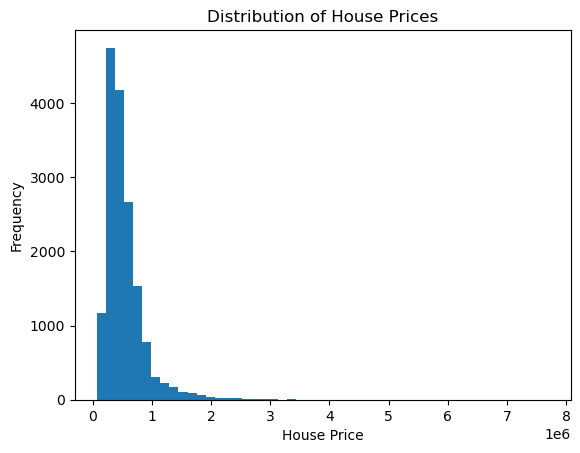

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(train_df["price"], bins=50)
plt.xlabel("House Price")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices")
plt.show()

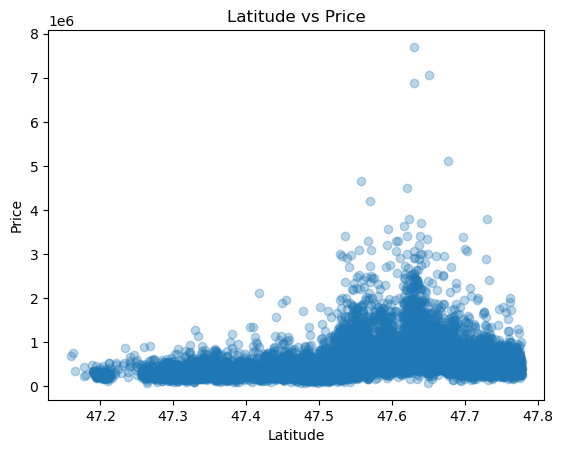

In [6]:
plt.figure()
plt.scatter(train_df["lat"], train_df["price"], alpha=0.3)
plt.xlabel("Latitude")
plt.ylabel("Price")
plt.title("Latitude vs Price")
plt.show()

In [7]:
# Drop non-feature columns
drop_cols = ["id", "date"]

train_clean = train_df.drop(columns=drop_cols)
test_clean = test_df.drop(columns=drop_cols)

In [8]:
X = train_clean.drop(columns=["price"])
y = train_clean["price"]

X_test = test_clean.copy()


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gbr = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)

preds = gbr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, preds))
r2 = r2_score(y_val, preds)

print("Baseline (Raw Price)")
print("RMSE:", rmse)
print("R²:", r2)

Baseline (Raw Price)
RMSE: 120108.65722619172
R²: 0.8850406462697022


In [11]:
y_log = np.log1p(y)

X_train_l, X_val_l, y_train_l, y_val_l = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

gbr_log = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr_log.fit(X_train_l, y_train_l)

log_preds = gbr_log.predict(X_val_l)
preds_exp = np.expm1(log_preds)

rmse_log = np.sqrt(mean_squared_error(y_val, preds_exp))
r2_log = r2_score(y_val, preds_exp)

print("Baseline (Log Price)")
print("RMSE:", rmse_log)
print("R²:", r2_log)

Baseline (Log Price)
RMSE: 119830.57891395342
R²: 0.8855723431118756


In [12]:
import numpy as np

# Copy clean data
train_fe = train_clean.copy()
test_fe = test_clean.copy()

# Age of house
train_fe["house_age"] = 2024 - train_fe["yr_built"]
test_fe["house_age"] = 2024 - test_fe["yr_built"]

# Renovation indicator
train_fe["was_renovated"] = (train_fe["yr_renovated"] > 0).astype(int)
test_fe["was_renovated"] = (test_fe["yr_renovated"] > 0).astype(int)

# Living area ratios
train_fe["basement_ratio"] = train_fe["sqft_basement"] / train_fe["sqft_living"]
test_fe["basement_ratio"] = test_fe["sqft_basement"] / test_fe["sqft_living"]

train_fe["lot_to_living_ratio"] = train_fe["sqft_lot"] / train_fe["sqft_living"]
test_fe["lot_to_living_ratio"] = test_fe["sqft_lot"] / test_fe["sqft_living"]

# Handle inf/nan from division
train_fe = train_fe.replace([np.inf, -np.inf], 0)
test_fe = test_fe.replace([np.inf, -np.inf], 0)

In [13]:
X_fe = train_fe.drop(columns=["price"])
y_log = np.log1p(train_fe["price"])

X_test_fe = test_fe.copy()

In [14]:
# Compute mean log price per zipcode
zip_price_mean = train_fe.groupby("zipcode")["price"].mean()

# Map to train & test
X_fe["zipcode_mean_price"] = train_fe["zipcode"].map(zip_price_mean)
X_test_fe["zipcode_mean_price"] = test_fe["zipcode"].map(zip_price_mean)

# Fill unseen zipcodes in test
global_mean = train_fe["price"].mean()
X_test_fe["zipcode_mean_price"] = X_test_fe["zipcode_mean_price"].fillna(global_mean)

# Drop raw zipcode
X_fe = X_fe.drop(columns=["zipcode"])
X_test_fe = X_test_fe.drop(columns=["zipcode"])

In [15]:
from sklearn.model_selection import train_test_split

X_train_fe, X_val_fe, y_train_fe, y_val_fe = train_test_split(
    X_fe, y_log, test_size=0.2, random_state=42
)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

gbr_fe = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.04,
    max_depth=4,
    subsample=0.9,
    random_state=42
)

gbr_fe.fit(X_train_fe, y_train_fe)

log_preds = gbr_fe.predict(X_val_fe)
preds = np.expm1(log_preds)

rmse_fe = np.sqrt(mean_squared_error(np.expm1(y_val_fe), preds))
r2_fe = r2_score(np.expm1(y_val_fe), preds)

print("Improved Baseline")
print("RMSE:", rmse_fe)
print("R²:", r2_fe)

Improved Baseline
RMSE: 114857.92336686011
R²: 0.8948721917587725


In [17]:
# Predict on full training set using the improved baseline
log_preds_full = gbr_fe.predict(X_fe)
preds_full = np.expm1(log_preds_full)

# Compute residuals
residuals = train_fe["price"].values - preds_full

# Absolute residuals
abs_residuals = np.abs(residuals)

# Attach residuals to dataframe
residual_df = train_fe.copy()
residual_df["predicted_price"] = preds_full
residual_df["residual"] = residuals
residual_df["abs_residual"] = abs_residuals

In [18]:
# Determine threshold
threshold = residual_df["abs_residual"].quantile(0.67)

# Select high-residual samples
high_residual_df = residual_df[residual_df["abs_residual"] >= threshold]

print("High residual samples:", high_residual_df.shape[0])

High residual samples: 5349


In [19]:
high_residual_df[["price", "predicted_price", "residual"]].head()

,price,predicted_price,residual
2,200000,264992.305577,-64992.305577
7,880000,597674.883564,282325.116436
11,995000,903383.066678,91616.933322
14,340000,285667.648768,54332.351232
21,399000,486289.663138,-87289.663138


In [20]:
high_residual_df.index.to_series().to_csv(
    "high_residual_ids.csv",
    index=False,
    header=["id"]
)

In [21]:
pd.read_csv("high_residual_ids.csv").head()

,id
0,2
1,7
2,11
3,14
4,21


In [22]:
# Save residual indices correctly
pd.DataFrame(
    {"id": high_residual_df.index.values}
).to_csv("high_residual_ids.csv", index=False)

print("Saved", len(high_residual_df), "residual IDs")

Saved 5349 residual IDs


In [24]:
import os
os.getcwd()

'C:\\Users\\DELL\\Downloads\\satellite-property-valuation\\Notebooks'

In [25]:
import os
import pandas as pd
import numpy as np

# =========================
# LOAD TRAIN DATA
# =========================
train_df = pd.read_excel("../Data/train.xlsx")

# =========================
# LOAD BASELINE PREDICTIONS
# =========================
baseline_preds = pd.read_csv("../baseline_train_predictions.csv")
# columns: id, baseline_pred

# =========================
# MERGE & COMPUTE RESIDUAL
# =========================
df = train_df.merge(baseline_preds, on="id")

df["residual"] = df["price"] - df["baseline_pred"]

# =========================
# FILTER HIGH-RESIDUAL SAMPLES
# =========================
high_residual_ids = pd.read_csv("../high_residual_ids.csv")["id"]

residual_df = df[df["id"].isin(high_residual_ids)].copy()

# =========================
# ADD IMAGE PATHS
# =========================
IMAGE_DIR = "../satellite_images/residual_train"

residual_df["image_path"] = residual_df["id"].apply(
    lambda x: os.path.join(IMAGE_DIR, f"{x}.png")
)

# =========================
# FINAL CHECK
# =========================
print("Residual dataframe shape:", residual_df.shape)
residual_df.head()

Residual dataframe shape: (0, 24)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,baseline_pred,residual,image_path


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

# =========================
# LOAD DATA
# =========================
train_df = pd.read_excel("../Data/train.xlsx")

# =========================
# SELECT FEATURES
# =========================
FEATURES = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
    "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement",
    "yr_built", "yr_renovated",
    "lat", "long",
    "sqft_living15", "sqft_lot15"
]

X = train_df[FEATURES]
y = train_df["price"]

# =========================
# TRAIN BASELINE MODEL
# =========================
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

model.fit(X, y)

# =========================
# PREDICT ON FULL TRAIN SET
# =========================
train_df["baseline_pred"] = model.predict(X)

# =========================
# SAVE TO CSV (IMPORTANT)
# =========================
baseline_preds = train_df[["id", "baseline_pred"]]
baseline_preds.to_csv("../baseline_train_predictions.csv", index=False)

print("Baseline predictions saved successfully")
baseline_preds.head()

Baseline predictions saved successfully


,id,baseline_pred
0,9117000170,277493.196560
1,6700390210,239306.015974
2,7212660540,263609.604108
3,8562780200,274100.140492
4,7760400350,254357.281951


In [27]:
import os
import pandas as pd
import numpy as np

# =========================
# LOAD TRAIN DATA
# =========================
train_df = pd.read_excel("../Data/train.xlsx")

# =========================
# LOAD BASELINE PREDICTIONS
# =========================
baseline_preds = pd.read_csv("../baseline_train_predictions.csv")
# columns: id, baseline_pred

# =========================
# MERGE & COMPUTE RESIDUAL
# =========================
df = train_df.merge(baseline_preds, on="id")

df["residual"] = df["price"] - df["baseline_pred"]

# =========================
# FILTER HIGH-RESIDUAL SAMPLES
# =========================
high_residual_ids = pd.read_csv("../high_residual_ids.csv")["id"]

residual_df = df[df["id"].isin(high_residual_ids)].copy()

# =========================
# ADD IMAGE PATHS
# =========================
IMAGE_DIR = "../satellite_images/residual_train"

residual_df["image_path"] = residual_df["id"].apply(
    lambda x: os.path.join(IMAGE_DIR, f"{x}.png")
)

# =========================
# FINAL CHECK
# =========================
print("Residual dataframe shape:", residual_df.shape)
residual_df.head()

Residual dataframe shape: (0, 24)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,baseline_pred,residual,image_path


In [28]:
residual_df["image_path"].apply(os.path.exists).value_counts()

Series([], Name: count, dtype: int64)

In [29]:
residual_df["image_path"].apply(os.path.exists).value_counts()

Series([], Name: count, dtype: int64)

In [30]:
import os
import pandas as pd
import numpy as np

# =========================
# LOAD TRAIN DATA
# =========================
train_df = pd.read_excel("../Data/train.xlsx")

# =========================
# LOAD BASELINE PREDICTIONS
# =========================
baseline_preds = pd.read_csv("../baseline_train_predictions.csv")

# =========================
# MERGE
# =========================
df = train_df.merge(baseline_preds, on="id")

# =========================
# COMPUTE RESIDUAL
# =========================
df["residual"] = df["price"] - df["baseline_pred"]

# =========================
# LOAD HIGH RESIDUAL *INDICES*
# =========================
high_residual_indices = pd.read_csv("../high_residual_ids.csv")["id"].values

# IMPORTANT: FILTER BY INDEX, NOT ID COLUMN
residual_df = df.loc[high_residual_indices].copy()

# =========================
# ADD IMAGE PATHS
# =========================
IMAGE_DIR = "../satellite_images/residual_train"

residual_df["image_path"] = residual_df.index.map(
    lambda x: os.path.join(IMAGE_DIR, f"{x}.png")
)

# =========================
# FINAL CHECK
# =========================
print("Residual dataframe shape:", residual_df.shape)
residual_df.head()

Residual dataframe shape: (5349, 24)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,baseline_pred,residual,image_path
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,1994,0,98003,47.2704,-122.313,1870,7455,263609.604108,-63609.604108,../satellite_images/residual_train\2.png
7,1126059095,20140526T000000,880000,3,2.00,2130,35169,1.0,0,0,...,1989,0,98072,47.7489,-122.123,2860,43560,585089.122443,294910.877557,../satellite_images/residual_train\7.png
11,7154200070,20141124T000000,995000,5,3.25,3970,8029,2.0,0,2,...,1979,0,98177,47.7764,-122.385,2520,8214,855183.710438,139816.289562,../satellite_images/residual_train\11.png
14,4273000095,20150511T000000,340000,4,1.75,1400,8374,1.0,0,0,...,1953,0,98166,47.4735,-122.344,1420,8360,262168.884729,77831.115271,../satellite_images/residual_train\14.png
21,4046500270,20140819T000000,399000,3,2.00,2100,31550,1.0,0,0,...,2010,0,98014,47.6907,-121.917,1860,18452,531356.289470,-132356.289470,../satellite_images/residual_train\21.png


In [31]:
residual_df["image_path"].apply(os.path.exists).value_counts()

image_path
True     5341
False       8
Name: count, dtype: int64

In [32]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd

# =========================
# DEVICE
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================
# LOAD PRETRAINED RESNET
# =========================
resnet = models.resnet18(pretrained=True)

# Remove final classification layer
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

# Freeze weights
for param in resnet.parameters():
    param.requires_grad = False

resnet = resnet.to(device)
resnet.eval()

# =========================
# IMAGE TRANSFORM
# =========================
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("ResNet18 loaded and ready")

Using device: cpu


C:\Users\DELL\anaconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18 loaded and ready


In [33]:
from tqdm import tqdm

image_features = []
image_ids = []

for idx, row in tqdm(residual_df.iterrows(), total=len(residual_df)):
    img_path = row["image_path"]

    try:
        img = Image.open(img_path).convert("RGB")
        img_tensor = image_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            features = resnet(img_tensor)

        # Flatten: (1, 512, 1, 1) → (512,)
        features = features.view(-1).cpu().numpy()

        image_features.append(features)
        image_ids.append(idx)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

 51%|███████████████████████████████████████▉                                      | 2738/5349 [01:41<00:56, 45.98it/s]

Error processing ../satellite_images/residual_train\8165.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8165.png'
Error processing ../satellite_images/residual_train\8166.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8166.png'
Error processing ../satellite_images/residual_train\8168.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8168.png'
Error processing ../satellite_images/residual_train\8170.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8170.png'
Error processing ../satellite_images/residual_train\8172.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8172.png'
Error processing ../satellite_images/residual_train\8175.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8175.png'
Error processing ../satellite_images/residual_train\8177.png: [Errno 2] No such file or directory: '../satellite_images/resi

 56%|███████████████████████████████████████████▌                                  | 2986/5349 [01:50<01:31, 25.96it/s]

Error processing ../satellite_images/residual_train\8888.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8888.png'


100%|██████████████████████████████████████████████████████████████████████████████| 5349/5349 [03:16<00:00, 27.26it/s]


In [34]:
from tqdm import tqdm
print("tqdm installed correctly")

tqdm installed correctly


In [35]:
image_features = []
image_ids = []

for idx, row in residual_df.iterrows():
    img_path = row["image_path"]

    try:
        img = Image.open(img_path).convert("RGB")
        img_tensor = image_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            features = resnet(img_tensor)

        features = features.view(-1).cpu().numpy()

        image_features.append(features)
        image_ids.append(idx)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

Error processing ../satellite_images/residual_train\8165.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8165.png'
Error processing ../satellite_images/residual_train\8166.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8166.png'
Error processing ../satellite_images/residual_train\8168.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8168.png'
Error processing ../satellite_images/residual_train\8170.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8170.png'
Error processing ../satellite_images/residual_train\8172.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8172.png'
Error processing ../satellite_images/residual_train\8175.png: [Errno 2] No such file or directory: '../satellite_images/residual_train\\8175.png'
Error processing ../satellite_images/residual_train\8177.png: [Errno 2] No such file or directory: '../satellite_images/resi

In [36]:
import numpy as np

image_features = np.array(image_features)
print(image_features.shape)

(5341, 512)


In [37]:
from sklearn.decomposition import PCA

# Reduce CNN features
pca = PCA(n_components=50, random_state=42)
image_features_pca = pca.fit_transform(image_features)

print("PCA shape:", image_features_pca.shape)
print("Explained variance:", pca.explained_variance_ratio_.sum())

PCA shape: (5341, 50)
Explained variance: 0.70937717


In [38]:
from sklearn.decomposition import PCA

for k in [30, 50, 75, 100]:
    pca = PCA(n_components=k, random_state=42)
    X_pca = pca.fit_transform(image_features)
    print(f"{k} components → variance retained: {pca.explained_variance_ratio_.sum():.3f}")

30 components → variance retained: 0.608
50 components → variance retained: 0.709
75 components → variance retained: 0.788
100 components → variance retained: 0.840


In [39]:
# Residual target
y_residual = residual_df.loc[image_ids, "residual"].values

print("Residual target shape:", y_residual.shape)

Residual target shape: (5341,)


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_features_pca,
    y_residual,
    test_size=0.2,
    random_state=42
)

# Residual regressor
residual_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

residual_model.fit(X_train, y_train)

# Predict residuals
residual_preds = residual_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, residual_preds))
r2 = r2_score(y_test, residual_preds)

print("Residual Model RMSE:", rmse)
print("Residual Model R²:", r2)

Residual Model RMSE: 97499.56612385409
Residual Model R²: -0.021482671498132877


In [41]:
# Absolute residual target
y_abs_residual = np.abs(residual_df.loc[image_ids, "residual"].values)

In [42]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

X = image_features_pca
y = y_abs_residual

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = ElasticNet(
    alpha=0.01,
    l1_ratio=0.5,
    random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("ElasticNet Residual RMSE:", rmse)
print("ElasticNet Residual R²:", r2)

ElasticNet Residual RMSE: 72574.55989760271
ElasticNet Residual R²: -0.012118655989530325


C:\Users\DELL\anaconda3\envs\torch_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.957e+12, tolerance: 1.927e+09
  model = cd_fast.enet_coordinate_descent(


In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=75, random_state=42)
image_features_pca = pca.fit_transform(image_features)

print("PCA shape:", image_features_pca.shape)
print("Explained variance:", pca.explained_variance_ratio_.sum())

PCA shape: (5341, 75)
Explained variance: 0.7876944


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    image_features_pca,
    y_residual,
    test_size=0.2,
    random_state=42
)

residual_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

residual_model.fit(X_train, y_train)

residual_preds = residual_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, residual_preds))
r2 = r2_score(y_test, residual_preds)

print("Residual Model RMSE:", rmse)
print("Residual Model R²:", r2)

Residual Model RMSE: 97826.1281575299
Residual Model R²: -0.028336775754556953


In [46]:
# Keep only rows with successfully extracted images
residual_df_aligned = residual_df.loc[image_ids].copy()

print("Aligned residual_df shape:", residual_df_aligned.shape)

Aligned residual_df shape: (5341, 24)


In [47]:
# Predict image-based residual corrections
image_corrections = residual_model.predict(image_features_pca)

# Assign safely
residual_df_aligned["image_correction"] = image_corrections
residual_df_aligned["final_price_pred"] = (
    residual_df_aligned["baseline_pred"] + residual_df_aligned["image_correction"]
)

residual_df_aligned[["price", "baseline_pred", "final_price_pred"]].head()

,price,baseline_pred,final_price_pred
2,200000,263609.604108,257519.580132
7,880000,585089.122443,601820.840972
11,995000,855183.710438,856125.497197
14,340000,262168.884729,291359.290333
21,399000,531356.289470,538737.755285


In [48]:
sample = residual_df_aligned.iloc[0]

In [49]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Baseline metrics
baseline_rmse = np.sqrt(
    mean_squared_error(residual_df_aligned["price"], residual_df_aligned["baseline_pred"])
)
baseline_r2 = r2_score(
    residual_df_aligned["price"], residual_df_aligned["baseline_pred"]
)

# Multimodal metrics
multi_rmse = np.sqrt(
    mean_squared_error(residual_df_aligned["price"], residual_df_aligned["final_price_pred"])
)
multi_r2 = r2_score(
    residual_df_aligned["price"], residual_df_aligned["final_price_pred"]
)

print("Baseline RMSE:", baseline_rmse)
print("Baseline R²:", baseline_r2)
print("\nMultimodal RMSE:", multi_rmse)
print("Multimodal R²:", multi_r2)

Baseline RMSE: 91450.68900153098
Baseline R²: 0.9323842080901641

Multimodal RMSE: 80471.45666651418
Multimodal R²: 0.9476450317208287


In [50]:
sample = residual_df_aligned.sample(1).iloc[0]
sample

id                                                    705730280
date                                            20140819T000000
price                                                    325000
bedrooms                                                      3
bathrooms                                                   2.5
sqft_living                                                1740
sqft_lot                                                   5267
floors                                                      2.0
waterfront                                                    0
view                                                          0
condition                                                     3
grade                                                         7
sqft_above                                                 1740
sqft_basement                                                 0
yr_built                                                   1999
yr_renovated                            

In [52]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor):
        # Forward pass
        output = self.model(input_tensor)

        # We use the mean activation as a proxy score
        score = output.mean()

        # Backward pass
        self.model.zero_grad()
        score.backward()

        # Compute Grad-CAM
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

In [54]:
# Enable gradients for Grad-CAM
for param in resnet.parameters():
    param.requires_grad = True

In [55]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor):
        input_tensor.requires_grad_(True)

        output = self.model(input_tensor)

        # Use mean activation as target score
        score = output.mean()

        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam


In [57]:
import torch
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-create model from scratch (NO HOOKS)
resnet_cam = models.resnet18(pretrained=True)
resnet_cam = torch.nn.Sequential(*list(resnet_cam.children())[:-1])
resnet_cam = resnet_cam.to(device)
resnet_cam.eval()

# Enable gradients (only for Grad-CAM)
for param in resnet_cam.parameters():
    param.requires_grad = True

print("Fresh ResNet loaded for Grad-CAM")

C:\Users\DELL\anaconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fresh ResNet loaded for Grad-CAM


In [58]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

import numpy as np

def generate(self, input_tensor):
    input_tensor.requires_grad_(True)

    output = self.model(input_tensor)
    score = output.mean()

    self.model.zero_grad()
    score.backward()

    weights = self.gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * self.activations).sum(dim=1, keepdim=True)
    cam = F.relu(cam)

    # 🔥 UPSAMPLE CAM TO IMAGE SIZE
    cam = F.interpolate(
        cam,
        size=(224, 224),
        mode="bilinear",
        align_corners=False
    )

    cam = cam.squeeze().detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam

NameError: name 'heatmap' is not defined

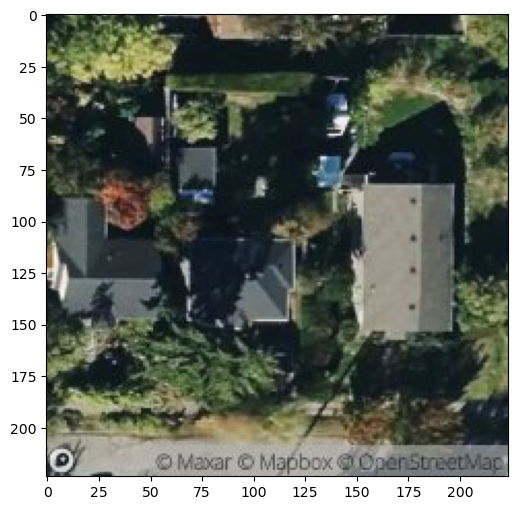

In [59]:
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.45)
plt.axis("off")
plt.title("Grad-CAM: Satellite Image Influence on Price Correction")
plt.show()

In [60]:
heatmap = cam.generate(input_tensor)

TypeError: Invalid shape () for image data

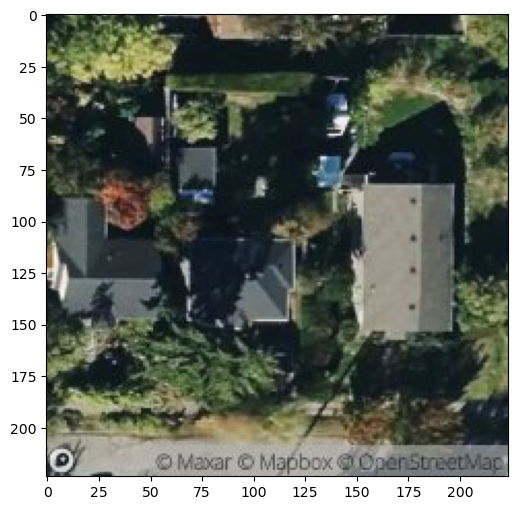

In [61]:
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.45)
plt.axis("off")
plt.title("Grad-CAM: Satellite Image Influence on Price Correction")
plt.show()

In [62]:
def generate(self, input_tensor):
    input_tensor.requires_grad_(True)

    output = self.model(input_tensor)
    score = output.mean()

    self.model.zero_grad()
    score.backward()

    # Grad-CAM computation
    weights = self.gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * self.activations).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)

    # Upsample to image size
    cam = torch.nn.functional.interpolate(
        cam,
        size=(224, 224),
        mode="bilinear",
        align_corners=False
    )

    # Convert to numpy safely
    cam = cam[0, 0].detach().cpu().numpy()   # 👈 EXPLICIT 2D

    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam

In [63]:
heatmap = cam.generate(input_tensor)
print("Heatmap shape:", heatmap.shape)

Heatmap shape: ()


In [64]:
target_layer = resnet_cam.layer4[-1]

AttributeError: 'Sequential' object has no attribute 'layer4'

In [65]:
img = Image.open(sample["image_path"]).convert("RGB")
input_tensor = image_transform(img).unsqueeze(0).to(device)

# 🔥 THIS IS THE KEY FIX
target_layer = resnet_cam.layer4[-1]

cam = GradCAM(resnet_cam, target_layer)
heatmap = cam.generate(input_tensor)

print("Heatmap shape:", heatmap.shape)

AttributeError: 'Sequential' object has no attribute 'layer4'

In [66]:
print(resnet_cam)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [67]:
img = Image.open(sample["image_path"]).convert("RGB")
input_tensor = image_transform(img).unsqueeze(0).to(device)

# 🔥 Correct last convolutional layer
target_layer = resnet_cam[7][-1]

cam = GradCAM(resnet_cam, target_layer)
heatmap = cam.generate(input_tensor)

print("Heatmap shape:", heatmap.shape)

AttributeError: 'GradCAM' object has no attribute 'generate'

In [68]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor):
        input_tensor.requires_grad_(True)

        output = self.model(input_tensor)
        score = output.mean()

        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)

        cam = F.interpolate(
            cam,
            size=(224, 224),
            mode="bilinear",
            align_corners=False
        )

        cam = cam[0, 0].detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

In [69]:
img = Image.open(sample["image_path"]).convert("RGB")
input_tensor = image_transform(img).unsqueeze(0).to(device)

target_layer = resnet_cam[7][-1]
cam = GradCAM(resnet_cam, target_layer)

heatmap = cam.generate(input_tensor)
print("Heatmap shape:", heatmap.shape)

C:\Users\DELL\anaconda3\envs\torch_env\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Heatmap shape: (224, 224)


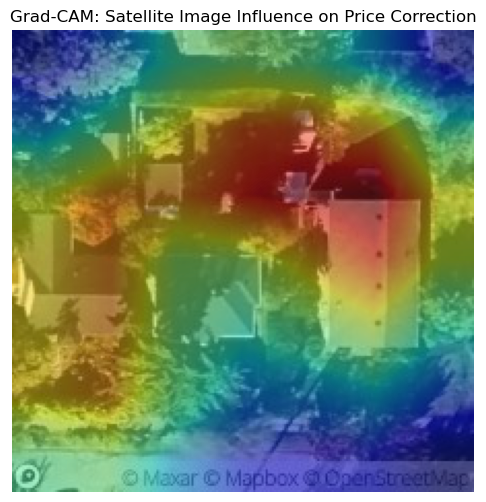

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.45)
plt.axis("off")
plt.title("Grad-CAM: Satellite Image Influence on Price Correction")
plt.show()

In [71]:
import pandas as pd
import numpy as np

In [72]:
test_df = pd.read_excel("../Data/test.xlsx")
print(test_df.shape)
test_df.head()

(5404, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [73]:
test_tabular = test_df[tabular_feature_columns]   # same columns as train
test_tabular_scaled = scaler.transform(test_tabular)

baseline_test_preds = baseline_model.predict(test_tabular_scaled)

NameError: name 'tabular_feature_columns' is not defined